In [1]:
import pandas as pd
llama_outputs = pd.read_json("https://raw.githubusercontent.com/Christianfoley/LLMLyricGen/main/data/model_outputs/llama-2-7b-chat-test-outputs.json")
lyre_outputs = pd.read_json("https://raw.githubusercontent.com/Christianfoley/LLMLyricGen/main/data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs.json")

In [2]:
import requests

swear_words = requests.get("https://raw.githubusercontent.com/chucknorris-io/swear-words/master/en").text
swear_words = swear_words.split("\n")
swear_words.remove("")
swear_words = [" " + w + " " for w in swear_words]

In [3]:
res = requests.get("https://github.com/Christianfoley/LLMLyricGen/tree/main/data/model_outputs")

In [4]:
import json
files = json.loads(res.text)

In [8]:
from collections import defaultdict

giant_dict = {}
for file in files["payload"]["tree"]["items"]:
    # ignore lora
    if "lora" not in file["path"]:
        swear_word_dict = defaultdict(int)
        outputs = pd.read_json("https://raw.githubusercontent.com/Christianfoley/LLMLyricGen/main/" + file["path"])
        for lyric in list(outputs["model_response"]):
            for swear_word in swear_words:
                swear_word_dict[swear_word] += lyric.count(swear_word)
                swear_word_dict["count"] += lyric.count(swear_word)
        giant_dict[file["path"]] = {x:y for x,y in swear_word_dict.items() if y!=0}

In [9]:
count_dict = {}
for key, value in giant_dict.items():
    count = 0
    for value in giant_dict[key].values():
        count += value
    count_dict[key] = count

In [10]:
count_dict

{'data/model_outputs/llama-2-7b-chat-temp-1-test-outputs.json': 34,
 'data/model_outputs/llama-2-7b-chat-test-outputs.json': 18,
 'data/model_outputs/llama-2-7b-test-outputs.json': 12,
 'data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs.json': 674,
 'data/model_outputs/lyre-chat-small-batch-checkpoint-100-test-outputs.json': 376,
 'data/model_outputs/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs.json': 686,
 'data/model_outputs/lyre-chat-small-batch-checkpoint-150-test-outputs.json': 556,
 'data/model_outputs/lyre-chat-small-batch-checkpoint-50-temp-1-test-outputs.json': 458,
 'data/model_outputs/lyre-chat-small-batch-checkpoint-50-test-outputs.json': 356,
 'data/model_outputs/lyre-small-batch-checkpoint-100-test-outputs.json': 148,
 'data/model_outputs/lyre-small-batch-checkpoint-150-test-outputs.json': 268,
 'data/model_outputs/lyre-small-batch-checkpoint-50-test-outputs.json': 218,
 'data/model_outputs/test_song_generations.json': 4182,
 'data/mo

In [21]:
group_dict = {"lyre-chat-temp-1":{}, "lyre-chat":{}, "lyre":{}}
for key in count_dict.keys():
    if "temp-1" in key:
        model_type = "lyre-chat-temp-1"
    elif "chat" in key:
        model_type = "lyre-chat"
    else:
        model_type = "lyre"
    if "llama" in key:
        epoch = 0
    elif "-50-" in key:
        epoch = 50
    elif "-100-" in key:
        epoch = 100
    elif "-150-" in key:
        epoch = 150
    group_dict[model_type][epoch] = count_dict[key]
    myKeys = list(group_dict[model_type].keys())
    myKeys.sort()
    group_dict[model_type] = {i: group_dict[model_type][i] for i in myKeys}

In [22]:
labels = group_dict.keys()
x = ["checkpoint-" + str(num) for num in [0, 50, 100, 150]]
y = [group_dict[key].values() for key in group_dict]
df = pd.DataFrame(columns=["model", "checkpoint","num_swear_words"])
checkpoints = ['0', '50', '100', '150']
for i in range(len(list(labels))):
    for j in range(len(list(y[i]))):
        df = df.append({"checkpoint": checkpoints[j], "model":list(labels)[i], "num_swear_words":list(y[i])[j]}, ignore_index=True)

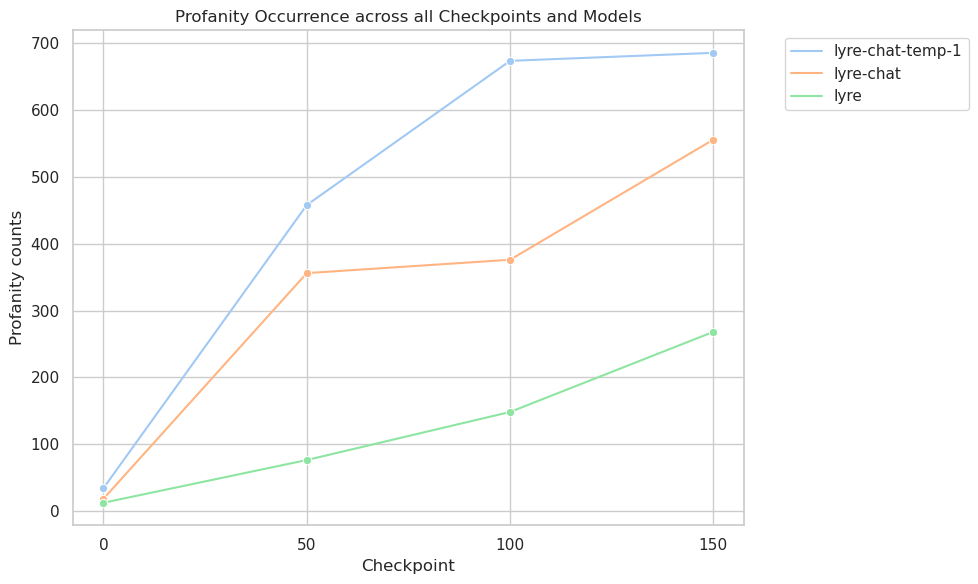

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.lineplot(data=df, x='checkpoint', y='num_swear_words', hue='model', marker='o', palette='pastel')

# Set labels and title
ax.set(xlabel='Checkpoint', ylabel='Profanity counts', title='Profanity Occurrence across all Checkpoints and Models')

# Show legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plot
plt.show()